# Background


### ~2014 (Almost Famous-ish)

 - Graduated from conservatory
 - falling out with music and the lifestyle
 - Rising interest in the sciences
 - Pixie Scientific + python
 - Had hair
 

![used-to-be-me](imgs/rick-guitar.jpeg)

### 2015 (Rise of the Machines)

    - equinox
    - internet research
    - coursera courses
    - Part time courses at Metis
    

 - [Python for Everybody](https://www.coursera.org/specializations/python)
 - [Python For Data Analysis](https://www.amazon.com/Python-Data-Analysis-Wrangling-IPython/dp/1491957662)
 - [Cartoon Guide to Statistics](https://www.amazon.com/Cartoon-Guide-Statistics-Larry-Gonick/dp/0062731025/ref=asc_df_0062731025/?tag=hyprod-20&linkCode=df0&hvadid=312130957577&hvpos=&hvnetw=g&hvrand=8988218495360739972&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9067609&hvtargid=pla-437618408572&psc=1)


<img src="imgs/stats-book.jpeg" alt="cartoon-stats" width="400"/>

### 2016 (Metis A New Hope)

 - Had a running start from self-study + part time courses
 - [pandas pandas pandas](http://tomaugspurger.github.io/modern-1-intro.html) (probably already out dated)
 - Botched Final Project
 
 
<img src="imgs/metis-final-project.png" alt="cartoon-stats" width="800"/>

### 2017 (Hunt for Red Jobtober)

    - It's hard
    - Lots of Practice
        - Got my spiel down. 
        - Pre-written cover letters.
        - Applied to everything
        - Bother Jen
        - Post in slack
        - Talk with your cohort-mates
    - More Practice!
        - Refined what I learned at metis
        - Kept learning
        - Made a portfolio


### 2017 (360i Robot)

 - Automation (csvs/excel --> python/pandas)
 - Data Infrastructure (AWS, ec2, s3, redshift, iam, lambda)
 - ETL (APIs, REST, SQL)
 - Optimization (Diminishing Returns, Scipy Optimize)

![not-a-robot](imgs/not-a-robot.png)
 

### 2019 (Better Will Hunting)

    - AB Testing
    - Data Engineering
    - Database management
    - Airflow
    - Large Scale Infrastructure
    

![better-com](imgs/better-com.png)

# Budget Optimization


    1) Building Models
    2) Using the models to "tune" spend
    

___1) Build Models___

Say you split your spend accross 3 brands within your business ("Brand1", "Brand2", "Brand3"). The first step is then to build a model that, given a budget, will predict the number of conversions generated from your spend.

![build_models](imgs/build_models.png)


___2) Optimize Budget___

Once we have these models built, we can then use them to vary the amount of money spent in the different brands, using the models to predict the outcome, until the outcome is the highest it can get.




Adjust the spend until we've reached the maximum output

!['adjust_spend'](imgs/optBudget2.png)

Notice that when we moved $1000 out of _Category2_ into the other two categories, we gained a total of 70 conversions at the expense of 10.

!['calculate_lift'](imgs/optBudget3.png)

In [2]:
from scipy import optimize, stats
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12,8)

## Budget Optimization With Scipy



### Curve Fit
`scipy.optimize.curve_fit(f,x,y, p0 = None)` sets the parameters based on [non-linear least squares](https://en.wikipedia.org/wiki/Least_squares#Differences_between_linear_and_nonlinear_least_squares).

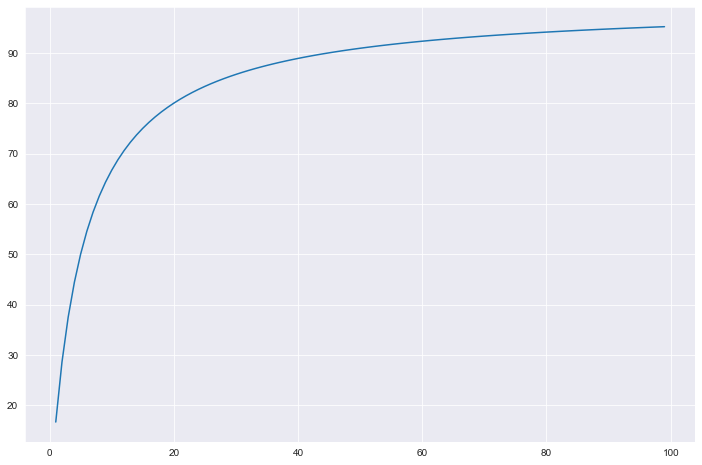

In [8]:
x = np.arange(1,100)

# Michaelis Menten Curve
def curve_func(x, b0, b1):
    return (b0 * x)/(b1 + x)

# parameters
b0 = 100
b1 = 5

y = curve_func(x,b0,b1)
plt.plot(x,y)

[100.   5.]


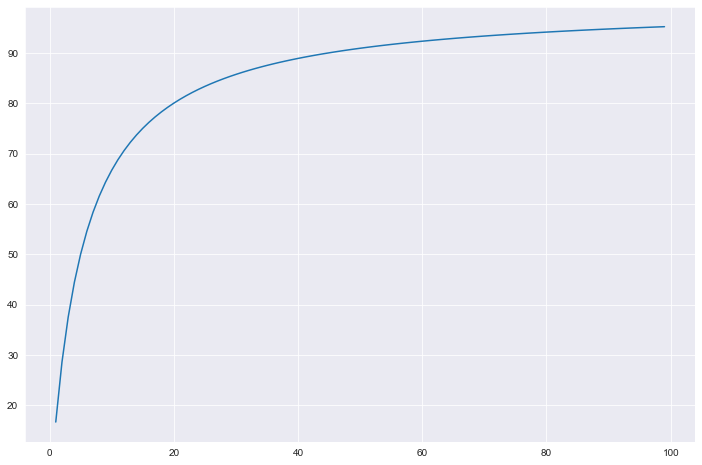

In [9]:
# returns the parameters for function `func` which produce the "best" fitting curve
betas, cov = optimize.curve_fit(curve_func,x,y)
y_pred = curve_func(x,*betas)
print(betas)
plt.plot(x,y_pred)

### Minimize

`scipy.optimize.minimize(func, starting_input)` can find the values of passed parameters that minimize the output of the function.

 > Minimize is the same as the negative of Maximize



In [11]:
# Find the value of x that maximizes output of our function
target = lambda x : -curve_func(x, b0, b1)

In [15]:
res = optimize.minimize(target, [1], tol=0.00001)

In [16]:
print(res.x) # optimal parameters
print(res.success) # whether or not the optimizer was successful
print(res.message) # Success or error message
print(res.fun) # the value of the objective function with optimal params
print(res.nit) # number of iterations.

[8118.59364042]
True
Optimization terminated successfully.
-99.93845088489998
26


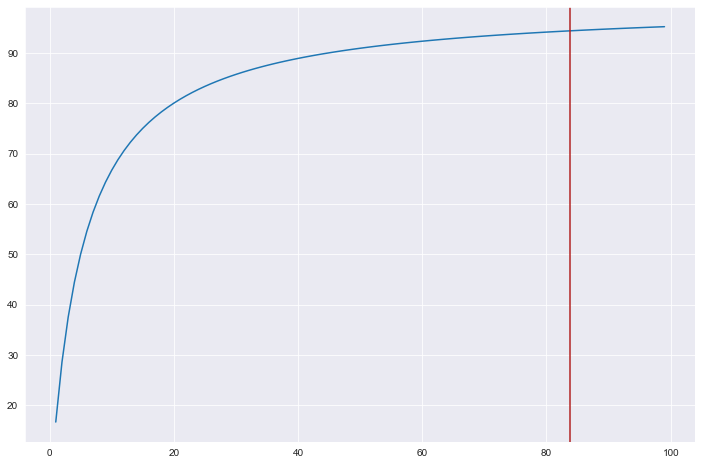

In [14]:
plt.plot(x,y)
plt.axvline(res.x[0], color='firebrick')

### Budget Optimization

___Curve Fit___: fit a curve for every brand.

___Optimize___: Change our target function to the _**total**_ output (sales)

In [17]:
df = pd.read_csv('static/market_data_final.csv', parse_dates=['Date'])
df.head()

,Date,Brand,Spend,Sales
0,2014-11-30,brand1,5776.36157,827.508282
1,2014-12-07,brand1,5014.68348,808.926138
2,2014-12-14,brand1,5166.06911,838.985698
3,2014-12-22,brand1,6966.43583,991.050451
4,2014-12-29,brand2,1484.27469,305.742635


In [18]:
df.Brand.unique()

array(['brand1', 'brand2', 'brand3', 'brand4', 'brand5'], dtype=object)

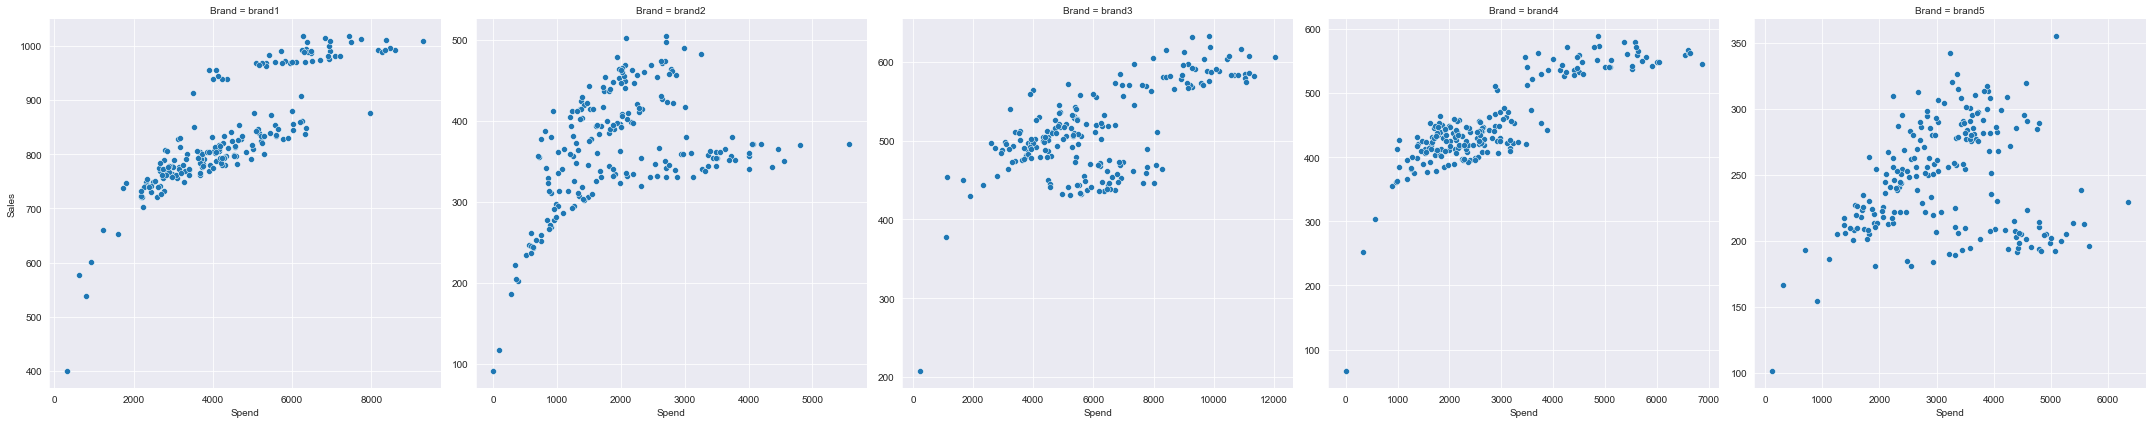

In [19]:
# visualize
grid = sns.FacetGrid(data = df, col = 'Brand', sharey=False, sharex=False, height=6)
grid.map(sns.scatterplot, 'Spend', 'Sales')

In [20]:
def fit_curves(df, **kwargs):
    """
    For a dataframe containing "Brand", "Spend", "Sales" columns,
    return parameters for models for each brand.
    
    Additional kwargs passed to scipy.optimize.curve_fit
    """
    # Initialize empty dict to hold parameters
    models = dict.fromkeys(df.Brand.unique())
    cov = dict.fromkeys(df.Brand.unique())
    
    # fit models for each brand
    for i, brand in enumerate(models):
        # x is spend
        x = df.loc[df.Brand == brand, 'Spend']
        xrange = np.linspace(0, x.max()*1.25, 1000)
        # y is sales
        y = df.loc[df.Brand == brand, 'Sales']
        # fit curve yield params
        params = optimize.curve_fit(curve_func, x, y, **kwargs)
        # params has model parameters and covariance estimates
        models[brand] = params[0]
        cov[brand] = params[1]

    return models, cov
 


def plot_models(df, models, cov=None):
    # Helper to plot the models against actuals
    fig, axes = plt.subplots(1,len(models), figsize=(32,8))
    for i, brand in enumerate(models):
        x = df.loc[df.Brand == brand, 'Spend']
        x_range = np.linspace(0, x.max()*1.25, 1000)
        y = df.loc[df.Brand == brand, 'Sales']
        axes[i].scatter(x,y)
        axes[i].plot(x_range,curve_func(x_range, *models[brand]))
        axes[i].set_title(brand)
        axes[i].set_xlabel('Spend', fontsize=13)
        axes[i].set_ylabel('Sales', fontsize=13)
    return fig, axes

In [21]:
models, cov = fit_curves(df)

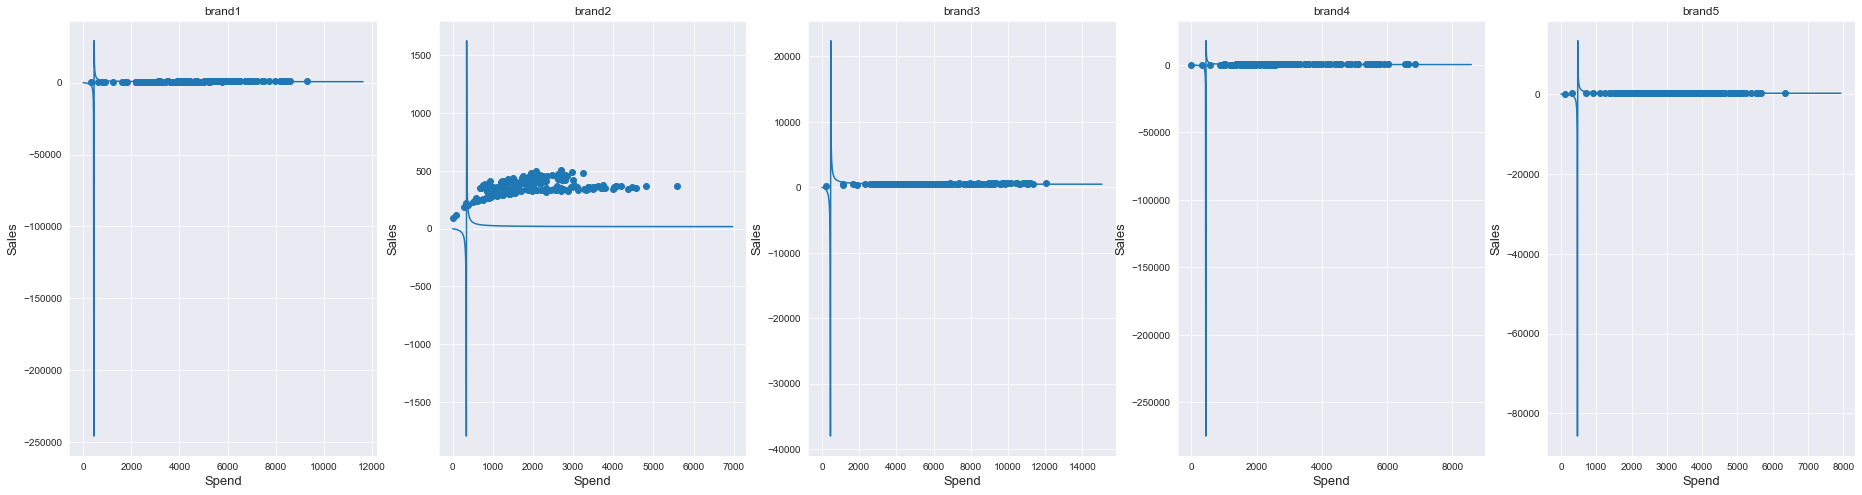

In [22]:
plot_models(df, models);

In [23]:
models

{'brand1': array([ 671.96875008, -443.50512536]),
 'brand2': array([  17.23287261, -345.12457991]),
 'brand3': array([ 460.44344115, -457.64639143]),
 'brand4': array([ 326.33089504, -438.49220004]),
 'brand5': array([ 193.27797675, -469.35935763])}

In [24]:
models, cov = fit_curves(df, bounds=(0,np.inf))

In [25]:
models

{'brand1': array([1063.57011957, 1061.98604008]),
 'brand2': array([442.81360119, 313.54656499]),
 'brand3': array([582.52941996, 708.16301554]),
 'brand4': array([604.12082437, 796.91599699]),
 'brand5': array([272.88355382, 286.68613982])}

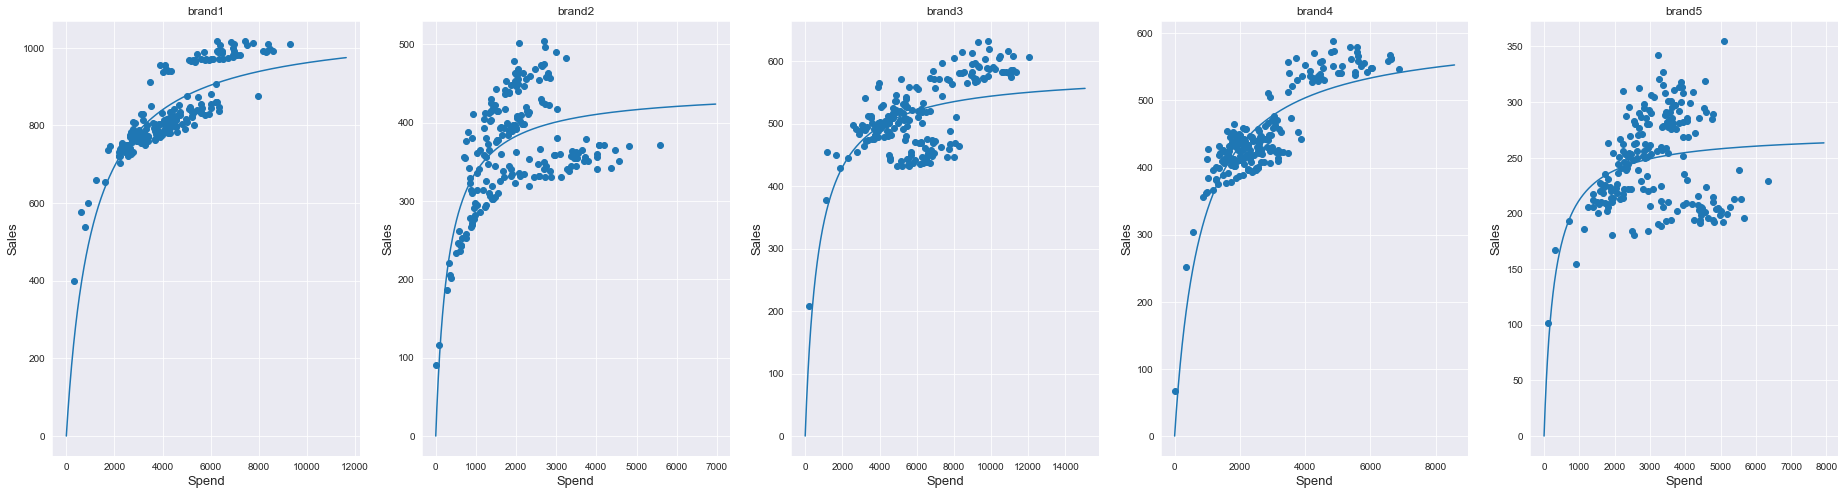

In [26]:
plot_models(df, models);

### Optimize

In [28]:
def target_func(spend_by_brand, params):
    # spend_by_brand is allocated spend for each brand
    # params are the parameters for that brands model
    return -sum([curve_func(spend_by_brand[i], *params[i]) for i in range(len(spend_by_brand))])

def optimize_budget(total_budget, models):
    # starting budget
    budget = np.ones(len(models)) * (total_budget/len(models))
    params = np.asarray(list(models.values()))
    
    # find budget array that minimizes the target function (negative conversion)
    result = optimize.minimize(
        target_func, 
        budget, 
        params,
        # inequality constraint means the result of `fun` must be non-negative
        constraints=[{'type': 'ineq', 'fun': lambda budg: total_budget - sum(budg)}]
    )
    print(result.message)
    print("Total Sales:", -result.fun)
    return dict(zip(models.keys(), result.x))

In [29]:
res = optimize_budget(20_000, models)
res

Optimization terminated successfully
Total Sales: 2563.988592352176


{'brand1': 7066.1893374341635,
 'brand2': 2592.2531334022583,
 'brand3': 4123.708548772676,
 'brand4': 4402.092231418255,
 'brand5': 1815.7567489726453}

 - Brand 1 has the highest sales/dollar and a high (slow) rate parameter so we spend the most there.
 - Brand 3 and 4 are similar but brand 3 has a slightly lower (faster) rate parameter
 - Brand 5 is the worst performing so we allocate the least.

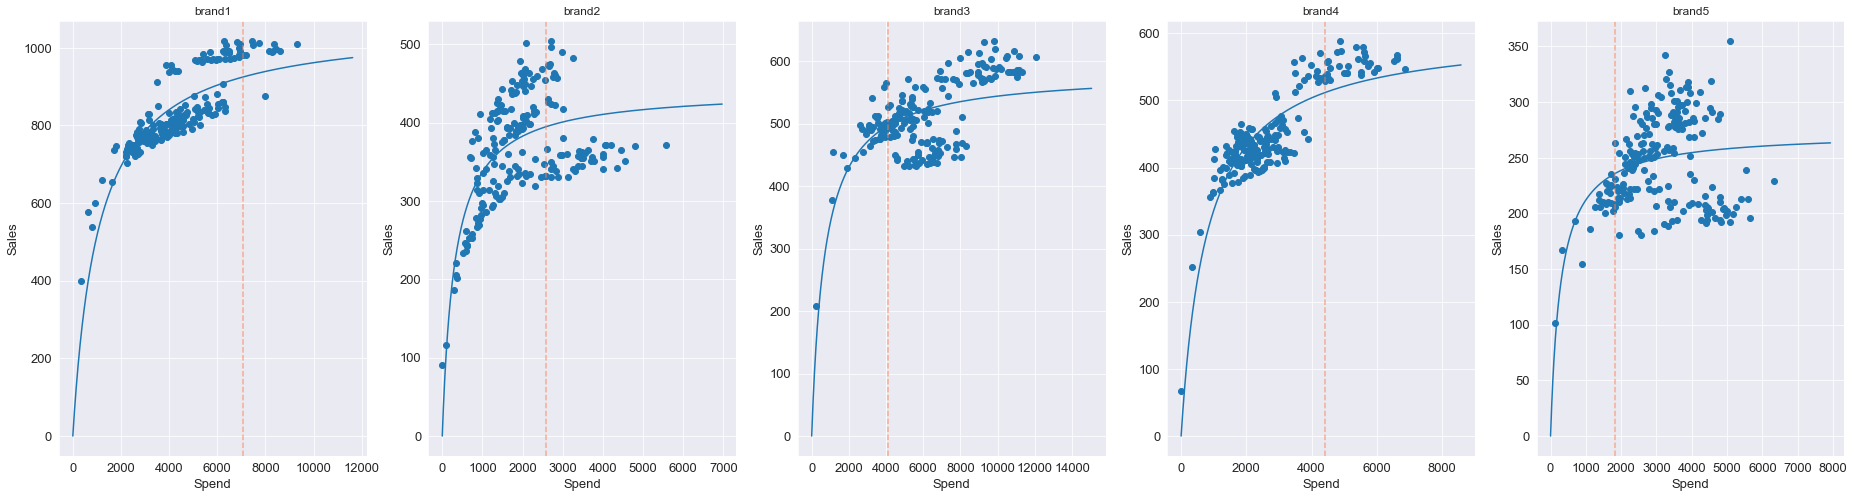

In [30]:
fig, axes = plot_models(df, models)
for i, ax in enumerate(axes):
    ax.axvline(list(res.values())[i], color='coral', linestyle='--', alpha=0.6)
    plt.setp(ax.get_xticklabels(), fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=13)

## Conclusion and Questions


    - Curve function (the model) can be any arbitrary model for each brand. Does NOT have to be the same for each.
    - However, you must make sure that the inputs are _controllable_!
    - When the model does not fit it's often good to try segmenting the data by other dimensions eg break out by product or by region.
    - Optimize curve fit returns uncertainty parameters. You can change the minimize function to account for that.







Notebook in Github: https://github.com/rshap91/Metis-Presentation-2021